In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from torsionfit.database import qmdatabase as ScanSet
import torsionfit.model as Model
from torsionfit.backends import sqlite_plus
from torsionfit import parameters
from parmed.charmm import CharmmParameterSet, CharmmPsfFile
import torsionfit.parameters as par
import numpy as np
from edward.models import Normal, Categorical, Uniform, Empirical, TransformedDistribution
import tensorflow as tf
from simtk import unit
import copy
import edward as ed
#from edward.util import check_latent_vars, copy
from collections import OrderedDict



In [2]:
# Turn off dihedral energy for to get residuals 
param = CharmmParameterSet('../param/par_all36_cgenff.prm', '../param/top_all36_cgenff.rtf')
structure = '../structure/butane.psf'
struct_parmed = CharmmPsfFile(structure)
scan = '../torsion_scans/MP2_torsion_scan/'

dih_list = [('CG331', 'CG321', 'CG321', 'CG331'),
            ('HGA2', 'CG321', 'CG321', 'HGA2'),
           ('CG331', 'CG321', 'CG321', 'HGA2')]
par.turn_off_params(param=param, structure=struct_parmed, dihedral=dih_list, copy=False)


In [3]:
scan = ScanSet.parse_psi4_out(scan, structure, pattern='*.out2')
scan = scan.remove_nonoptimized()
scan.compute_energy(param)

[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/0/butane_0.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/10/butane_10.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/20/butane_20.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~


/Users/sternc1/anaconda/envs/tensorflow3/lib/python3.6/site-packages/torsionfit-0+untagged.581.g8a2414f.dirty-py3.6.egg/torsionfit/database/qmdatabase.py:190: UserWarning: Warning: Optimizer failed for /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/10/butane_10.out2
  warnings.warn("Warning: Optimizer failed for {}".format(f))


[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/30/butane_30.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/40/butane_40.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/50/butane_50.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/60/butane_60.out2 WARNING] In logfilepa

[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/320/butane_320.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/330/butane_330.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/340/butane_340.out2 WARNING] In logfileparser.py, line 471, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_examples/butane/edward/../torsion_scans/MP2_torsion_scan/350/butane_350.out2 WARNING] In l

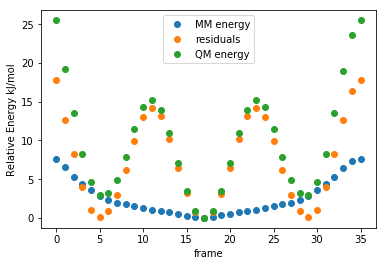

In [4]:
plt.plot(scan.mm_energy, 'o', label='MM energy')
plt.plot(scan.delta_energy, 'o', label='residuals')
plt.plot(scan.qm_energy, 'o', label='QM energy')
plt.legend()
plt.xlabel('frame')
plt.ylabel('Relative Energy kJ/mol');

In [5]:
# Edward Model No reversible jump
# TensorFlow interactive session
tf.InteractiveSession()

# Precalculate phis and cosines
to_optimize = [('CG331', 'CG321', 'CG321', 'CG331'),
              ('HGA2', 'CG321', 'CG321', 'HGA2'), 
              ('CG331', 'CG321', 'CG321', 'HGA2')]
scan.build_phis(to_optimize)
phis_np = np.zeros((36, 6, len(to_optimize)))
n_np = np.array([1., 2., 3., 4., 5., 6.])
for i, t in enumerate(to_optimize):
    phis_np[:, :, i] = (1+np.cos(scan.phis[t][:, np.newaxis]*n_np[:, np.newaxis])).sum(-1)
phis = tf.constant(phis_np, dtype=tf.float32)  

# Model will fit to residuals
residual_data = tf.constant(copy.deepcopy(scan.delta_energy.value_in_unit(unit=unit.kilojoule_per_mole)), 
                            dtype=tf.float32)


/Users/sternc1/anaconda/envs/tensorflow3/lib/python3.6/site-packages/torsionfit-0+untagged.581.g8a2414f.dirty-py3.6.egg/torsionfit/database/qmdatabase.py:602: UserWarning: type frequency values don't sum up to number of dihedral
  warnings.warn("type frequency values don't sum up to number of dihedral")
/Users/sternc1/anaconda/envs/tensorflow3/lib/python3.6/site-packages/torsionfit-0+untagged.581.g8a2414f.dirty-py3.6.egg/torsionfit/database/qmdatabase.py:617: UserWarning: torsion ('HGA3', 'CG331', 'CG321', 'HGA2') is not in list of phis to precalculate but is in the structure. Are you sure you did not want to fit it?
  "Are you sure you did not want to fit it?".format(torsion_type))
/Users/sternc1/anaconda/envs/tensorflow3/lib/python3.6/site-packages/torsionfit-0+untagged.581.g8a2414f.dirty-py3.6.egg/torsionfit/database/qmdatabase.py:617: UserWarning: torsion ('HGA3', 'CG331', 'CG321', 'CG321') is not in list of phis to precalculate but is in the structure. Are you sure you did not wan

In [57]:
T = 10000
ds = tf.contrib.distributions
K = Normal(loc=tf.zeros((len(n_np), len(to_optimize))), scale=1.0)
Fourier_sum = tf.reduce_sum(tf.reduce_sum(tf.multiply(phis, K), axis=1), axis=1)
Fourier_sum_rel = Fourier_sum - tf.reduce_min(Fourier_sum)
proposal_K = Normal(loc=K, scale=0.02)
qK = Empirical(tf.Variable(tf.zeros([T, 6, 3])))
log_sigma = Uniform(low=[-4.6052], high=[3.453])
sigma = TransformedDistribution(distribution=log_sigma, bijector=ds.bijectors.Exp(), name='sigma')
proposal_sigma = Normal(loc=sigma, scale=0.02)
qsigma = Empirical(tf.Variable(tf.zeros([T, 1])))

In [58]:
likelihood = Normal(loc=Fourier_sum_rel, scale=1.0)

In [59]:
# Set up MH inference 
inference = ed.MetropolisHastings(latent_vars={K: qK}, 
                                  proposal_vars={K: proposal_K}, 
                                  data={likelihood: residual_data})

In [60]:
inference.run()

10000/10000 [100%] ██████████████████████████████ Elapsed: 14s | Acceptance Rate: 0.574


In [61]:
test = inference.latent_vars[K]

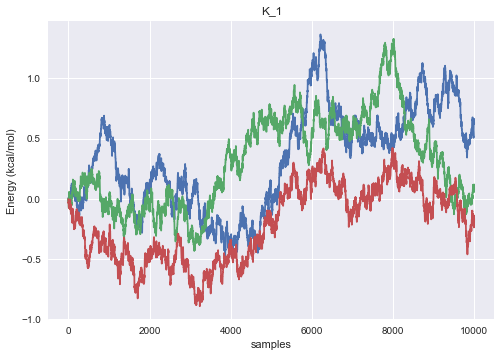

In [107]:
plt.plot(test.get_variables()[0].eval()[:,0]);
plt.title('K_1')
plt.xlabel('samples')
plt.ylabel('Energy (kcal/mol)');

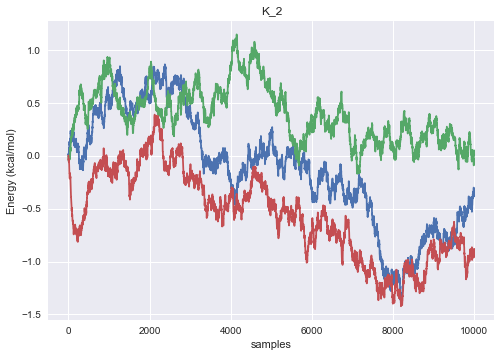

In [108]:
plt.plot(test.get_variables()[0].eval()[:,1]);
plt.title('K_2')
plt.xlabel('samples')
plt.ylabel('Energy (kcal/mol)');

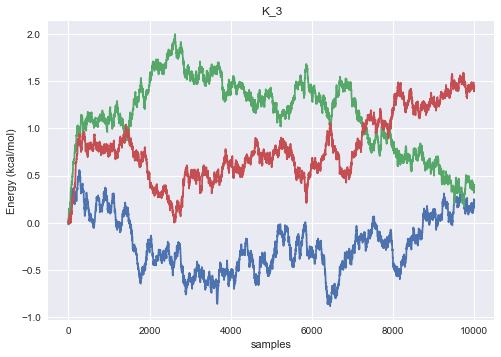

In [109]:
plt.plot(test.get_variables()[0].eval()[:,2]);
plt.title('K_3')
plt.xlabel('samples')
plt.ylabel('Energy (kcal/mol)');

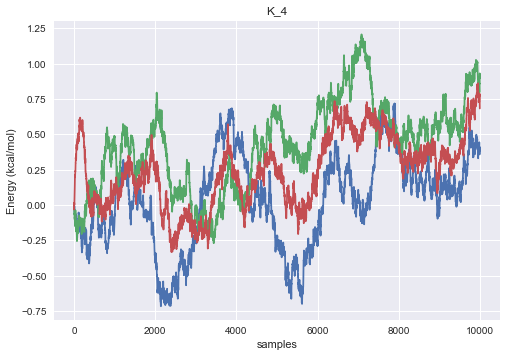

In [110]:
plt.plot(test.get_variables()[0].eval()[:,3]);
plt.title('K_4')
plt.xlabel('samples')
plt.ylabel('Energy (kcal/mol)');

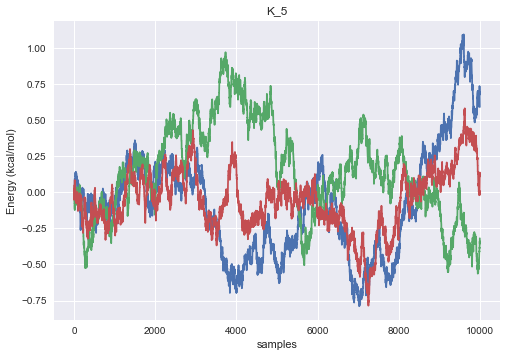

In [111]:
plt.plot(test.get_variables()[0].eval()[:,4]);
plt.title('K_5')
plt.xlabel('samples')
plt.ylabel('Energy (kcal/mol)');

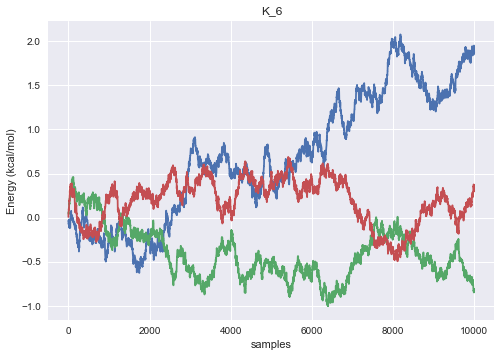

In [112]:
plt.plot(test.get_variables()[0].eval()[:,5]);
plt.title('K_6')
plt.xlabel('samples')
plt.ylabel('Energy (kcal/mol)');

In [84]:
def observed_eval(trace):
    energy_trace = np.zeros([len(trace), 36])
    for i in range(len(trace)):
        fourier_sum = (trace[i][np.newaxis, :,:]*phis_np).sum(1).sum(1)
        energy_trace[i] = fourier_sum - min(fourier_sum)
    return energy_trace

In [85]:
traces = inference.latent_vars[K].get_variables()[0].eval()

In [86]:
energy = observed_eval(traces)

In [88]:
import seaborn as sns

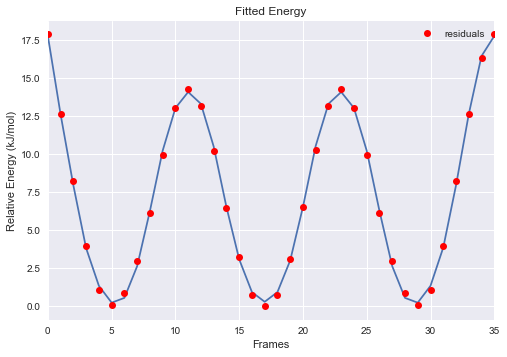

In [116]:
sns.tsplot(energy[1000:])
plt.plot(scan.delta_energy, 'o', color='red', label='residuals')
plt.title('Fitted Energy')
plt.xlabel('Frames')
plt.ylabel('Relative Energy (kJ/mol)')
plt.legend();